In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
BASE_PATH = '/content/drive/Shared drives/Citadel Datathon 2020 Summer/datasets'
UK_INFLATION_CSV = 'UK_inflation.csv'
UK_HOUSE_PRICE_CSV = 'UK_house_price.csv'
UK_HOUSE_SALES_VOLUME_CSV = 'UK_house_sales_volume.csv'

# 1.Read Data

In [5]:
london_inflation = pd.read_csv(os.path.join(BASE_PATH, UK_INFLATION_CSV))

In [6]:
price = pd.read_csv(os.path.join(BASE_PATH, UK_HOUSE_PRICE_CSV))
vol = pd.read_csv(os.path.join(BASE_PATH, UK_HOUSE_SALES_VOLUME_CSV))

In [7]:
price.index = pd.to_datetime(price['Unnamed: 0'])
price = price.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 34',  'Unnamed: 37',  'Unnamed: 47'])

In [8]:
price.head()

,City of London,Barking & Dagenham,Barnet,Bexley,Brent,Bromley,Camden,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith & Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington & Chelsea,Kingston upon Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,Inner London,Outer London,NORTH EAST,NORTH WEST,YORKS & THE HUMBER,EAST MIDLANDS,WEST MIDLANDS,EAST OF ENGLAND,LONDON,SOUTH EAST,SOUTH WEST,England
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1995-01-01,91448.98487,50460.22660,93284.51832,64958.09036,71306.56698,81671.47692,120932.8881,69158.16225,79885.89069,72514.69096,62300.10169,61296.52637,124902.8602,76287.56947,84769.52599,68000.13774,73834.82964,72231.70537,92516.48557,182694.8326,80875.84843,67770.98843,60491.26109,82070.61330,53539.31919,72189.58437,109326.1245,67885.20344,71536.97357,59865.18995,61319.44913,88559.04381,133025.2772,78251.97650,72958.79836,42076.35411,43958.48001,44803.42878,45544.52227,48527.52339,56701.59610,74435.76052,64018.87894,54705.15790,53202.77128
1995-02-01,82202.77314,51085.77983,93190.16963,64787.92069,72022.26197,81657.55944,119508.8622,68951.09542,80897.06551,73155.19746,60993.26863,63187.08332,122087.7180,78901.21036,83396.10525,69393.51294,75031.06960,71051.55852,94342.37334,182345.2463,81230.13524,65381.51908,60869.27091,79982.74872,53153.88306,72141.62610,111103.0394,64799.06480,70893.20851,62318.53353,60252.12246,88641.01678,131468.3096,75885.70201,72937.88262,42571.98949,43925.42289,44528.80721,46051.57066,49341.29029,56593.59475,72777.93709,63715.02399,54356.14843,53096.15490
1995-03-01,79120.70256,51268.96956,92247.52435,64367.49344,72015.76274,81449.31143,120282.2131,68712.44341,81379.86288,72190.44144,61377.83464,63593.29935,120635.9467,78521.94855,83416.23759,69368.02407,74188.66949,72097.99411,93465.86407,182878.8231,81111.48848,66336.51868,60288.03002,80661.68279,53458.26393,72501.35502,107325.4742,65763.29719,70306.83844,63938.67686,60871.08493,87124.81523,132260.3417,76591.59947,72714.53478,42369.72984,44434.86810,45200.46775,45383.82395,49442.17973,56171.18278,73896.84204,64113.60858,53583.07667,53201.28430
1995-04-01,77101.20804,53133.50526,90762.87492,64277.66881,72965.63094,81124.41227,120097.8990,68610.04641,82188.90498,71442.92235,61927.72460,65139.64403,121424.6241,79545.57477,83567.88439,69444.26215,73911.40591,71890.28339,93344.49305,184176.9168,81672.80476,66388.77160,59471.03136,79990.54333,54479.75395,72228.60295,106875.0000,63073.62117,69411.94390,66233.19383,60971.39722,87026.00225,133370.2036,76851.56697,72591.92469,42095.84360,44267.77960,45614.34341,46124.23045,49455.93299,56567.89582,74455.28754,64623.22395,54786.01938,53590.85480
1995-05-01,84409.14932,53042.24852,90258.00033,63997.13588,73704.04743,81542.61561,119929.2782,68844.91690,82077.05525,70630.77955,63512.99103,66193.99212,124433.5390,79374.03490,83853.65615,68534.52248,73117.12416,72877.47219,94346.39917,191474.1141,82123.51084,69035.11076,58551.38387,80873.98643,55803.95958,72366.64122,107707.6799,64420.49933,69759.21989,66432.85846,61494.16938,86518.05945,133911.1117,79129.19443,72752.99414,43266.45165,44223.61973,44830.98563,45878.00396,50369.66188,56479.80183,75432.02786,64530.36358,54698.83831,53678.24041


In [9]:
vol.index = pd.to_datetime(vol['Unnamed: 0.1'])
vol = vol.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 34',  'Unnamed: 37',  'Unnamed: 47'])
vol = vol.iloc[1:, :]
vol = vol.astype(int)

In [10]:
price.columns

Index(['City of London', 'Barking & Dagenham', 'Barnet', 'Bexley', 'Brent',
       'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich',
       'Hackney', 'Hammersmith & Fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington & Chelsea',
       'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
       'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster',
       'Inner London', 'Outer London', 'NORTH EAST', 'NORTH WEST',
       'YORKS & THE HUMBER', 'EAST MIDLANDS', 'WEST MIDLANDS',
       'EAST OF ENGLAND', 'LONDON', 'SOUTH EAST', 'SOUTH WEST', 'England'],
      dtype='object')

# 2.Preprocessing

In [11]:
# set host and London boroughs
host_boroughs = ['Barking & Dagenham', 'Greenwich', 'Hackney', 'Newham', 'Tower Hamlets', 'Waltham Forest']
central_host_boroughs = ['Brent', 'Westminster', 'Kensington & Chelsea','Hammersmith & Fulham', 'Wandsworth']
london_boroughs = price.columns[:33]

In [12]:
london_boroughs

Index(['City of London', 'Barking & Dagenham', 'Barnet', 'Bexley', 'Brent',
       'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich',
       'Hackney', 'Hammersmith & Fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington & Chelsea',
       'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
       'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster'],
      dtype='object')

In [13]:
other_borough = []
for ele in london_boroughs:
   if ele not in central_host_boroughs and ele not in host_boroughs:
      other_borough.append(ele)
other_borough

['City of London',
 'Barnet',
 'Bexley',
 'Bromley',
 'Camden',
 'Croydon',
 'Ealing',
 'Enfield',
 'Haringey',
 'Harrow',
 'Havering',
 'Hillingdon',
 'Hounslow',
 'Islington',
 'Kingston upon Thames',
 'Lambeth',
 'Lewisham',
 'Merton',
 'Redbridge',
 'Richmond upon Thames',
 'Southwark',
 'Sutton']

In [14]:
crisis_multiplier = pd.DataFrame(price.loc["2008-06-01",] / price.loc["2009-04-01",])
crisis_multiplier = crisis_multiplier.reset_index()
crisis_multiplier.columns=['area', 'crisis_multiplier']
crisis_multiplier.head()

,area,crisis_multiplier
0,City of London,1.218124
1,Barking & Dagenham,1.253056
2,Barnet,1.189196
3,Bexley,1.170539
4,Brent,1.102469


In [15]:
# change price shape
price_unstack = pd.DataFrame(price.unstack()).reset_index()
price_unstack.columns = ['area', 'date', 'price']
price_unstack = price_unstack[(price_unstack['date']<pd.to_datetime("2008-07-01")) | (price_unstack['date']>pd.to_datetime("2009-03-01"))]

# crisis adjustment
price_unstack = price_unstack.merge(crisis_multiplier, on="area", how="left")
price_unstack.loc[price_unstack['date']<pd.to_datetime("2008-07-01"), 'crisis_multiplier'] = 1
price_unstack = price_unstack[price_unstack['area'].isin(london_boroughs)]
price_unstack = price_unstack.reset_index()
price_unstack

,index,area,date,price,crisis_multiplier
0,0,City of London,1995-01-01,9.144898e+04,1.000000
1,1,City of London,1995-02-01,8.220277e+04,1.000000
2,2,City of London,1995-03-01,7.912070e+04,1.000000
3,3,City of London,1995-04-01,7.710121e+04,1.000000
4,4,City of London,1995-05-01,8.440915e+04,1.000000
...,...,...,...,...,...
9697,9697,Westminster,2019-11-01,9.552646e+05,1.057497
9698,9698,Westminster,2019-12-01,9.609431e+05,1.057497
9699,9699,Westminster,2020-01-01,1.001284e+06,1.057497
9700,9700,Westminster,2020-02-01,1.042884e+06,1.057497


In [16]:
def before_after(x):
    """determine if before or after announce"""
    if x < pd.to_datetime('2005-07-06'):
        return 0
    return 1
def before_after_construct(x):
    """determine if before or after announce"""
    if x < pd.to_datetime('2007-07-01'):
        return 0
    return 1

#### Dataset inside London

In [17]:
# add dummy variables: time
price_unstack['before_after'] = price_unstack['date'].apply(before_after_construct)

In [18]:
# multiply by inflation
price_unstack['year'] = price_unstack['date'].dt.year
price_unstack = price_unstack.merge(london_inflation[['year', 'multiplier']], on='year', how='left')
price_unstack.dropna(inplace=True)
price_unstack['price_inflated'] = price_unstack['price'] * price_unstack['multiplier']

In [19]:
# crisis multiplier
price_unstack['price_inflated'] = price_unstack['price_inflated']*price_unstack['crisis_multiplier']
price_unstack

,index,area,date,price,crisis_multiplier,before_after,year,multiplier,price_inflated
0,0,City of London,1995-01-01,9.144898e+04,1.000000,0,1995,1.89,1.728386e+05
1,1,City of London,1995-02-01,8.220277e+04,1.000000,0,1995,1.89,1.553632e+05
2,2,City of London,1995-03-01,7.912070e+04,1.000000,0,1995,1.89,1.495381e+05
3,3,City of London,1995-04-01,7.710121e+04,1.000000,0,1995,1.89,1.457213e+05
4,4,City of London,1995-05-01,8.440915e+04,1.000000,0,1995,1.89,1.595333e+05
...,...,...,...,...,...,...,...,...,...
9682,9682,Westminster,2018-08-01,9.823558e+05,1.057497,1,2018,1.00,1.038839e+06
9683,9683,Westminster,2018-09-01,1.023157e+06,1.057497,1,2018,1.00,1.081986e+06
9684,9684,Westminster,2018-10-01,1.025837e+06,1.057497,1,2018,1.00,1.084819e+06
9685,9685,Westminster,2018-11-01,1.030332e+06,1.057497,1,2018,1.00,1.089573e+06


In [20]:
# add time period stamps
price_unstack['River'] = (price_unstack['area'].isin(host_boroughs)) * 1
price_unstack['Central'] = (price_unstack['area'].isin(central_host_boroughs)) * 1
price_unstack['Other'] = (price_unstack['area'].isin(other_borough)) * 1
# add more interactions
price_unstack['before_after x River'] = price_unstack['River'] * price_unstack['before_after']
price_unstack['before_after x Central'] = price_unstack['Central'] * price_unstack['before_after']
price_unstack['before_after x Other'] = price_unstack['Other'] * price_unstack['before_after']

In [21]:
price_unstack

,index,area,date,price,crisis_multiplier,before_after,year,multiplier,price_inflated,River,Central,Other,before_after x River,before_after x Central,before_after x Other
0,0,City of London,1995-01-01,9.144898e+04,1.000000,0,1995,1.89,1.728386e+05,0,0,1,0,0,0
1,1,City of London,1995-02-01,8.220277e+04,1.000000,0,1995,1.89,1.553632e+05,0,0,1,0,0,0
2,2,City of London,1995-03-01,7.912070e+04,1.000000,0,1995,1.89,1.495381e+05,0,0,1,0,0,0
3,3,City of London,1995-04-01,7.710121e+04,1.000000,0,1995,1.89,1.457213e+05,0,0,1,0,0,0
4,4,City of London,1995-05-01,8.440915e+04,1.000000,0,1995,1.89,1.595333e+05,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9682,9682,Westminster,2018-08-01,9.823558e+05,1.057497,1,2018,1.00,1.038839e+06,0,1,0,0,1,0
9683,9683,Westminster,2018-09-01,1.023157e+06,1.057497,1,2018,1.00,1.081986e+06,0,1,0,0,1,0
9684,9684,Westminster,2018-10-01,1.025837e+06,1.057497,1,2018,1.00,1.084819e+06,0,1,0,0,1,0
9685,9685,Westminster,2018-11-01,1.030332e+06,1.057497,1,2018,1.00,1.089573e+06,0,1,0,0,1,0


# 3.BoxCox

In [22]:
def boxcox(a):
  # convert to gaussian dist
  y, lam = stats.boxcox(a)
  print(y)
  # y = np.log(y)
  # check with qq plot
  fig, ax = plt.subplots(figsize=(20, 10))
  prob = stats.probplot(y, dist=stats.norm, plot=ax)
  plt.show()
  return y, lam

# 4.Hedonic Model

## 4.1Logged Price

In [23]:
# equal years
price_unstack_ey = price_unstack[(price_unstack['date']>=pd.to_datetime("2001-01-01")) & (price_unstack['date']<=pd.to_datetime("2014-09-01"))]
price_unstack_ey = price_unstack_ey.reset_index()

[1.56986901 1.56976781 1.56975283 ... 1.57003557 1.57003679 1.57003731]


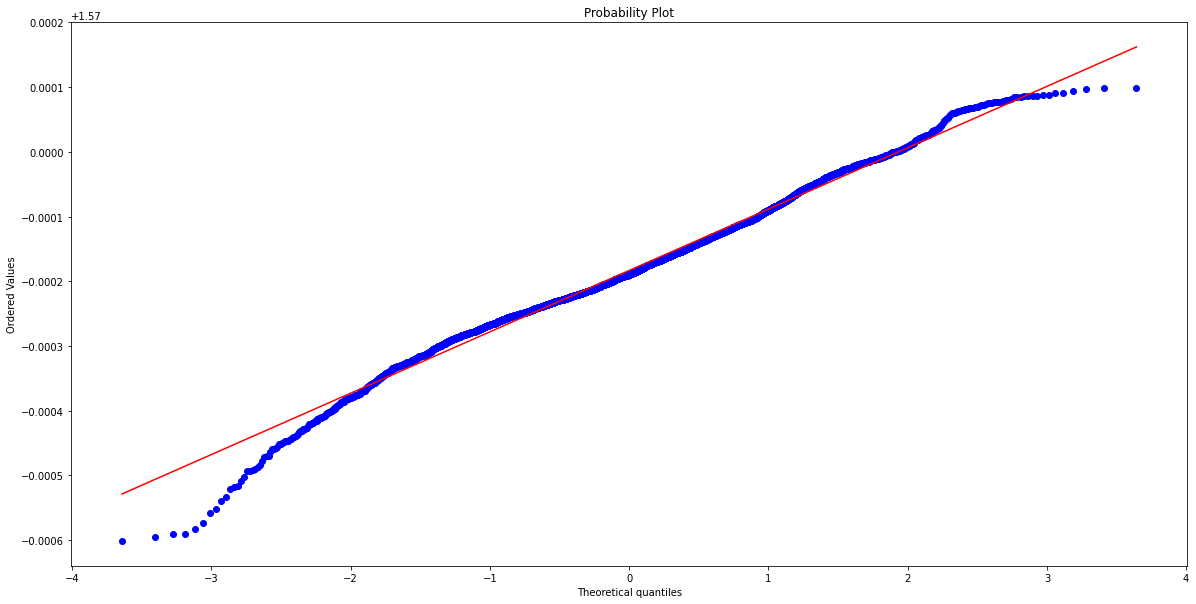

In [24]:
price_unstack_ey['y'], lamb = boxcox(price_unstack_ey['price_inflated'])

In [25]:
price_unstack_ey

,level_0,index,area,date,price,crisis_multiplier,before_after,year,multiplier,price_inflated,River,Central,Other,before_after x River,before_after x Central,before_after x Other,y
0,72,72,City of London,2001-01-01,284262.1358,1.000000,0,2001,1.60,4.548194e+05,0,0,1,0,0,0,1.569869
1,73,73,City of London,2001-02-01,198137.0177,1.000000,0,2001,1.60,3.170192e+05,0,0,1,0,0,0,1.569768
2,74,74,City of London,2001-03-01,189033.0279,1.000000,0,2001,1.60,3.024528e+05,0,0,1,0,0,0,1.569753
3,75,75,City of London,2001-04-01,205494.0961,1.000000,0,2001,1.60,3.287906e+05,0,0,1,0,0,0,1.569779
4,76,76,City of London,2001-05-01,223458.8283,1.000000,0,2001,1.60,3.575341e+05,0,0,1,0,0,0,1.569804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5143,9631,9631,Westminster,2014-05-01,896171.4371,1.057497,1,2014,1.09,1.032992e+06,0,1,0,0,1,0,1.570028
5144,9632,9632,Westminster,2014-06-01,923345.4157,1.057497,1,2014,1.09,1.064314e+06,0,1,0,0,1,0,1.570033
5145,9633,9633,Westminster,2014-07-01,941640.9299,1.057497,1,2014,1.09,1.085403e+06,0,1,0,0,1,0,1.570036
5146,9634,9634,Westminster,2014-08-01,949689.7261,1.057497,1,2014,1.09,1.094681e+06,0,1,0,0,1,0,1.570037


In [26]:
y = price_unstack_ey['y']
X = price_unstack_ey[['before_after','River', 'Central', 'Other', 'before_after x River', 'before_after x Central', 'before_after x Other']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit_regularized(method='elastic_net',alpha=0.1, L1_wt=1.0, start_params=None)
print(res.params)

x1       0.000000
x2       0.000000
x3       0.000000
x4       0.000000
x5       0.000000
x6       0.000000
x7       0.000000
const    1.469817
dtype: float64


In [27]:
def reverse(res_c, bc_lambda_c):
    print((res_c.params[-1] * bc_lambda_c + 1) ** (1 / bc_lambda_c))
    return ((res_c.params+res_c.params[-1]) * bc_lambda_c + 1) ** (1 / bc_lambda_c) - ((res_c.params[-1]) * bc_lambda_c + 1) ** (1 / bc_lambda_c)

In [64]:
## Bigmodel
y = price_unstack_ey['y']
X = price_unstack_ey[['before_after','River', 'Central', 'before_after x River', 'before_after x Central']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     809.1
Date:                Sun, 19 Jul 2020   Prob (F-statistic):               0.00
Time:                        16:11:15   Log-Likelihood:                 41861.
No. Observations:                5148   AIC:                        -8.371e+04
Df Residuals:                    5142   BIC:                        -8.367e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          7.547e-05   2.43e-06     31.044      0.0

In [65]:
reverse(res,lamb)

324203.9016349392


x1        98420.227410
x2       -62690.135605
x3       150058.010157
x4        13014.458633
x5         2932.349749
const              NaN
dtype: float64

In [28]:
## 1.Submodel: River
y = price_unstack_ey['y']
X = price_unstack_ey[['before_after','River', 'before_after x River']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     691.2
Date:                Sun, 19 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:41:43   Log-Likelihood:                 41239.
No. Observations:                5148   AIC:                        -8.247e+04
Df Residuals:                    5144   BIC:                        -8.244e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          7.599e-05   2.48e-06     30.690      0.0

In [29]:
reverse(res,lamb)

345575.8173112124


x1       111303.471323
x2       -84062.051277
x3        13828.584575
const              NaN
dtype: float64

In [30]:
## 2.Submodel: Other
y = price_unstack_ey['y']
X = price_unstack_ey[['before_after','Other', 'before_after x Other']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     357.8
Date:                Sun, 19 Jul 2020   Prob (F-statistic):          4.66e-211
Time:                        14:41:44   Log-Likelihood:                 40855.
No. Observations:                5148   AIC:                        -8.170e+04
Df Residuals:                    5144   BIC:                        -8.168e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          8.329e-05   4.18e-06     19.930      0.0

In [31]:
reverse(res,lamb)

333475.5180645366


x1       117223.461901
x2        -9271.616421
x3        -8406.413604
const              NaN
dtype: float64

In [32]:
## 3.Submodel: Central
y = price_unstack_ey['y']
X = price_unstack_ey[['before_after','Central', 'before_after x Central']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     1018.
Date:                Sun, 19 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:41:44   Log-Likelihood:                 41567.
No. Observations:                5148   AIC:                        -8.313e+04
Df Residuals:                    5144   BIC:                        -8.310e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          7.805e-05   2.28e-06     34.214      0.0

In [33]:
reverse(res,lamb)

308828.38410450297


x1        94059.219447
x2       165433.527697
x3          194.512853
const              NaN
dtype: float64

In [34]:
def zone(x):
    if x in host_boroughs:
        return "River Zone"
    elif x in central_host_boroughs:
        return "Central Zone"
    elif x in other_borough:
        return "Other"

In [35]:
price_unstack_ey['zone'] = price_unstack_ey['area'].apply(zone)
# price_unstack_ey

In [36]:
price_unstack_ey1 = pd.DataFrame(price_unstack_ey.groupby(['date', 'zone']).mean()['price_inflated'])
price_unstack_ey1 = price_unstack_ey1.reset_index()

In [37]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.line(price_unstack_ey1, x='date', y='price_inflated', color="zone", template="xgridoff", width=1000, height=600)

fig.update_layout(title="London Real Estate Price Trend by Zones", xaxis_title="DATE", yaxis_title="Price Inflation Adjusted")

fig.show()

In [ ]:
import seaborn as sns
price_unstack_ey_pivot = price_unstack_ey[['area']]

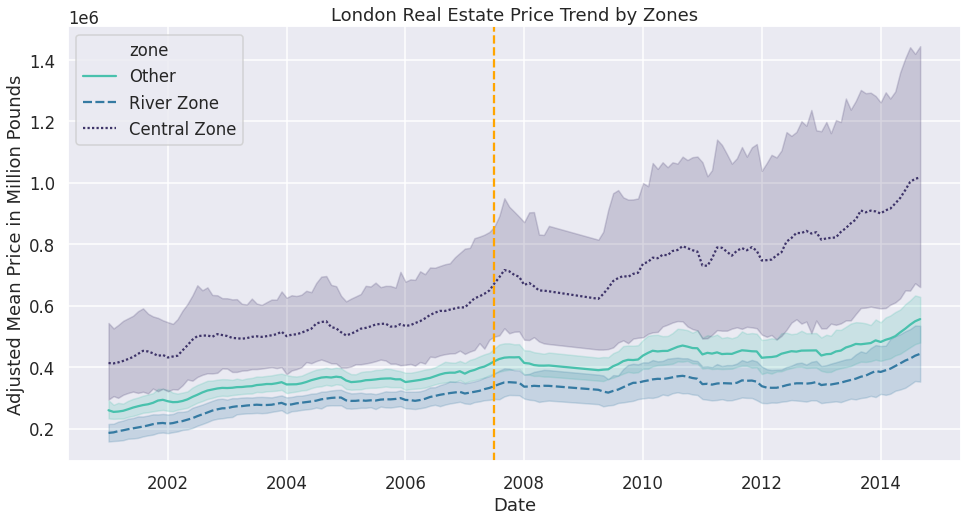

In [74]:
plt.figure(figsize=(16, 8))
sns.set_context("talk")
palette = sns.color_palette("mako_r", 3)
ax = sns.lineplot(x='date', y='price_inflated', style="zone",
                  hue="zone", palette=palette, data=price_unstack_ey,legend="brief")
ax.legend(loc='upper left')
ax.axvline(pd.to_datetime("2007-07-01"), color='orange', linestyle="dashed")
ax.set(xlabel='Date', ylabel='Adjusted Mean Price in Million Pounds')
ax.set_title('London Real Estate Price Trend by Zones')
# ax.ticklabel_format(style='plain', axis='y')
plt.show()

In [39]:
## For ANOVA plot
a = price_unstack_ey[['y', 'zone', 'before_after', 'price_inflated', 'date']]
a.columns=['Price Transformed', 'Zone', 'Timestamp: after announcement', 'Adjusted Price', 'Date']
#a['Price Transformed'] = (a['Price Transformed']-1.5697)*10000
a.to_csv('foranova.csv', index=False)

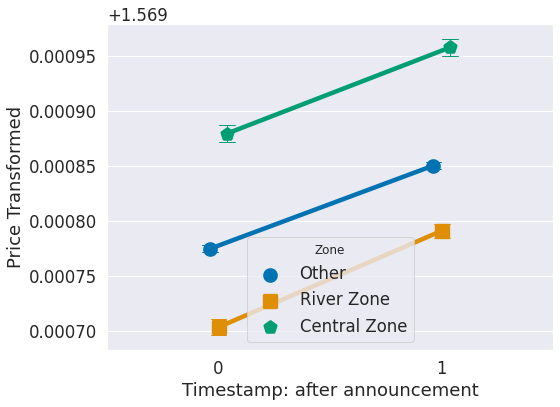

In [40]:

plt.figure(figsize=(8, 6))
sns.set(rc={"lines.linewidth": 2.5}, font_scale=1.5)
g = sns.pointplot(data=a, x='Timestamp: after announcement', y='Price Transformed', hue='Zone', dodge=True, markers=['o', 's', 'p'],
	      capsize=.07, errwidth=1, palette='colorblind')

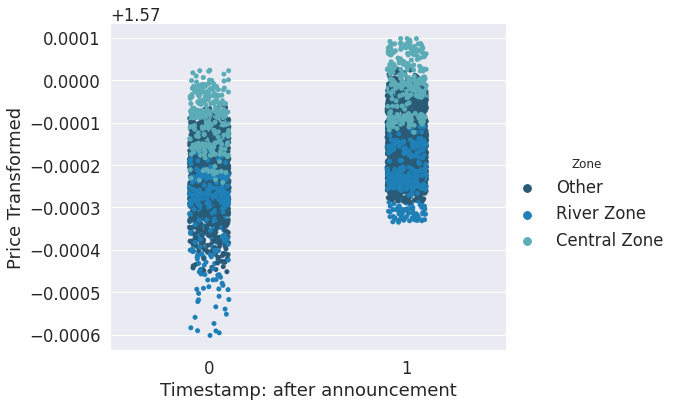

In [41]:
sns.set(rc={"lines.linewidth": 2.5}, font_scale=1.5)
sns.catplot(data=a, x='Timestamp: after announcement', y='Price Transformed', hue='Zone', palette="YlGnBu_d", height=6, aspect=1.3)


In [42]:
X = price_unstack_england[['before_after', 'if_host', 'if_host x before_after']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(price_unstack_england['price_inflated'].pctm_change()[1:].values, X[1:, ]).fit()
print(res.summary())

NameError: ignored

## 4.3 Two Models: one before, one after



In [ ]:
price_unstack_ey_before = price_unstack_ey[price_unstack_ey['date'] < pd.to_datetime('2007-07-01')]
price_unstack_ey_after = price_unstack_ey[price_unstack_ey['date'] >= pd.to_datetime('2007-07-01')]

In [ ]:
print(price_unstack_ey_before.shape)
print(price_unstack_ey_after.shape)

before

In [ ]:
price_unstack_ey_before['y'] = boxcox(price_unstack_ey_before['price_inflated'])

In [ ]:
y = price_unstack_ey_before['y']
X = price_unstack_ey_before[['River', 'Central']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

After

In [ ]:
price_unstack_ey_after['y'] = boxcox(price_unstack_ey_after['price_inflated'])

In [ ]:
y = price_unstack_ey_after['y']
X = price_unstack_ey_after[['River', 'Central']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())